# Sample-level embeddings

Held-out intermediates are projected into PCA space.

In [ ]:
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

from sklearn.decomposition import PCA

sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)
sns.set_palette('colorblind')

In [2]:
RESULTS_FILE = "out/results/GAT_2024-05-23-16-24-07_results.h5ad"  # No-Graph model
# RESULTS_FILE = "out/results/GAT_2024-05-23-16-23-45_results.h5ad"  # GAT model
FOLD = 4
ddata = ad.read_h5ad(RESULTS_FILE.replace(".h5ad", f"_donor_{FOLD}.h5ad"))
ddata.uns["perf_test"]

{'accuracy': 0.7777777777777778,
 'f1': 0.8000000000000002,
 'precision': 0.8,
 'recall': 0.8,
 'roc_auc': 0.8999999999999999}

In [43]:
# In the latest version of the dataset, the outliers are already removed, so we don't need to do it again:
# outliers = ['11326252', '11624423', '15114174', '15144878', '20147440', '20225925', '20730959', '50101785', '50105725', '50107583']
# ddata.obs["outlier"] = ddata.obs_names.isin(outliers)
# ddata = ddata[~ddata.obs_names.isin(outliers)].copy()

# # Show heatmap of the data that clearly shows the outliers
# X_cat = np.concatenate([
#     ddata[ddata.obs_names.isin(outliers)].X, 
#     ddata[~ddata.obs_names.isin(outliers)].X,
# ])
# plt.imshow(X_cat, aspect='auto')
# plt.colorbar()
# plt.show()

In [44]:
# ddata = ddata[ddata.obs["cv_set"] != "heldout"].copy()

<Axes: ylabel='Frequency'>

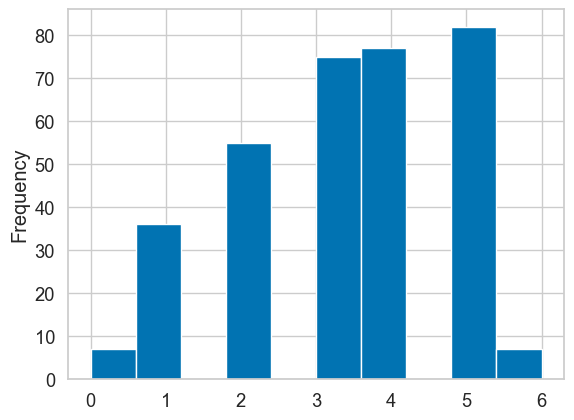

In [16]:
ddata.obs["braaksc"].plot(kind="hist")

In [63]:
wang_labels = []
for i, donor in enumerate(ddata.obs_names):
    dddata = ddata[ddata.obs_names == donor].copy().obs
    cogdx = dddata["cogdx"].values[0]
    braaksc = dddata["braaksc"].values[0]
    ceradsc = dddata["ceradsc"].values[0]
    if cogdx == 4 and braaksc >= 4 and ceradsc <= 2:
        wang_labels.append("AD")
    elif cogdx == 1 and braaksc <= 3 and ceradsc >= 3:
        wang_labels.append("CT")
    else:
        wang_labels.append("Other")
ddata.obs["wang_label"] = wang_labels
ddata.obs["Disease State"] = ddata.obs["wang_label"].map(
    {"AD": "AD", "CT": "Healthy", "Other": "Intermediate"}
)

ddata.obs["reagan_desc"] = ddata.obs["niareagansc"].map({4: "No AD", 3: "Low", 2: "Int", 1: "High"})
ddata.obs["reagan_dich"] = ddata.obs["niareagansc"].map({4: 0, 3: 0, 2: 1, 1: 1})

ddata.obs["cogdx_desc"] = ddata.obs["cogdx"].map({1: "NCI", 2: "MCI", 3: "MCI+", 4: "AD", 5: "AD+", 6: "Other"})
ddata.obs["cogdx_dich"] = ddata.obs["cogdx"].map({1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 0})

ddata.obs["y_true"] = ddata.obs["wang_label"].map({"AD": 1, "CT": 0, "Other": 2})
ddata.obs["acc"] = 1 - np.abs(ddata.obs["cogdx_dich"] - ddata.obs["y_pred"])

ddata.obs["sex"] = ddata.obs["msex"].map({0: "Female", 1: "Male"})

In [64]:
ddata_noint = ddata[ddata.obs["cv_set"] != "heldout"].copy()

pca = PCA(n_components=50).fit(ddata_noint.X)
x_noint_pca = pca.transform(ddata_noint.X)
x_full_pca = pca.transform(ddata.X)

# TODO: set to parametric UMAP here!!
# mapper = ParametricUMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.5).fit(x_noint_pca)
# x_noint_umap = mapper.transform(x_noint_pca)
# x_umap = mapper.transform(x_full_pca)

# ddata.obs["UMAP1"] = x_umap[:, 0]
# ddata.obs["UMAP2"] = x_umap[:, 1]
ddata.obs["PCA1"] = x_full_pca[:, 0]
ddata.obs["PCA2"] = x_full_pca[:, 1]
ddata.obs["PCA3"] = x_full_pca[:, 2]
ddata.obs["PCA4"] = x_full_pca[:, 3]

# Slice again, because we added new columns
ddata_noint = ddata[ddata.obs["cv_set"] != "heldout"].copy()

In [65]:
# mapper1d = ParametricUMAP(n_components=1, random_state=42, n_neighbors=15, min_dist=0.5).fit(x_noint_pca)
# x_noint_umap1d = mapper1d.transform(x_noint_pca)
# x_umap1d = mapper1d.transform(x_full_pca)

# ddata.obs["UMAP1D"] = x_umap1d[:, 0]

# # Slice again, because we added new columns
# ddata_noint = ddata[ddata.obs["cv_set"] != "heldout"].copy()

In [66]:
MARKER_SIZE = 50

In [67]:
ddata.obs["y_pred"]

projid
1211411     0.565429
3713990     0.736742
3889845     0.689862
6804844     0.040600
7253015     0.847239
              ...   
94430339    0.383561
95491648    0.127552
95919181    0.179322
96095092    0.084792
98953007    0.752922
Name: y_pred, Length: 339, dtype: float64

(0.0, 25.0)

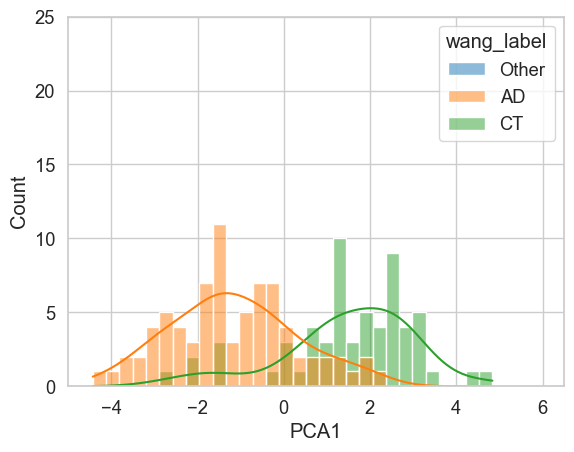

In [68]:
sns.histplot(ddata_noint.obs, x="PCA1", hue="wang_label", hue_order=["Other", "AD", "CT"], bins=30, palette="tab10", kde=True, common_norm=False)
plt.xlim(-5, 6.5)
plt.ylim(0, 25)

In [69]:
ddata_int = ddata[ddata.obs["cv_set"] == "heldout"].copy()

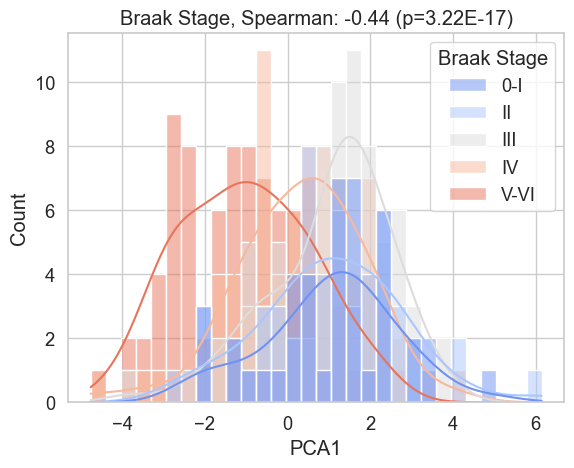

In [70]:
# Group Braak stages
ddata.obs["Braak Stage"] = ddata.obs["braaksc"].map(
    {0: "0-I", 1: "0-I", 2: "II", 3: "III", 4: "IV", 5: "V-VI", 6: "V-VI"})

sp = spearmanr(ddata.obs["PCA1"], ddata.obs["Braak Stage"])
plt.figure()
sns.histplot(ddata.obs, x="PCA1", hue="Braak Stage", bins=30, kde=True, common_norm=False, 
             palette="coolwarm",
             hue_order=["0-I", "II",  "III", "IV", "V-VI"])
plt.title(f"Braak Stage, Spearman: {sp.correlation:.2f} (p={sp.pvalue:.2E})")
plt.show()

<Axes: ylabel='Frequency'>

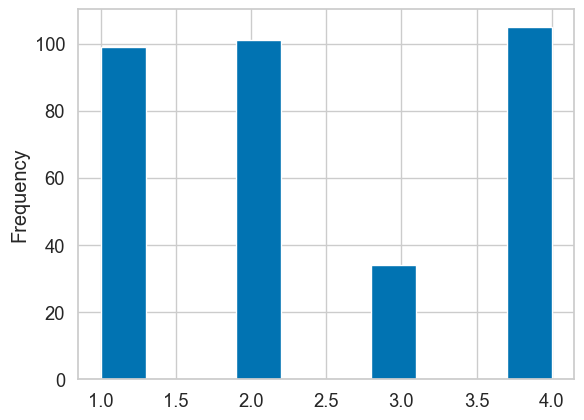

In [71]:
ddata.obs["ceradsc"].plot(kind="hist")

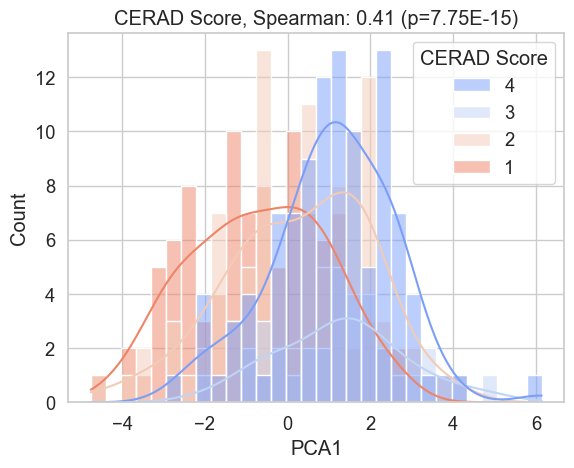

In [72]:
ddata.obs["CERAD Score"] = ddata.obs["ceradsc"].map({0: "0", 1: "1", 2: "2", 3: "3", 4: "4"})

sp = spearmanr(ddata.obs["PCA1"], ddata.obs["CERAD Score"])
plt.figure()
sns.histplot(ddata.obs, x="PCA1", hue="CERAD Score", bins=30, kde=True, common_norm=False, 
             palette="coolwarm", hue_order=["4", "3", "2", "1"])
plt.title(f"CERAD Score, Spearman: {sp.correlation:.2f} (p={sp.pvalue:.2E})")
plt.show()

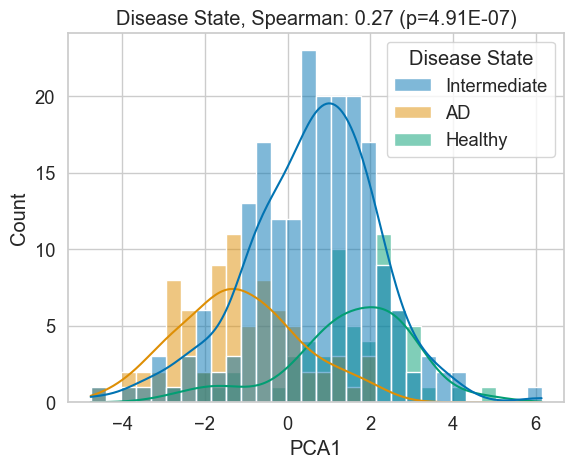

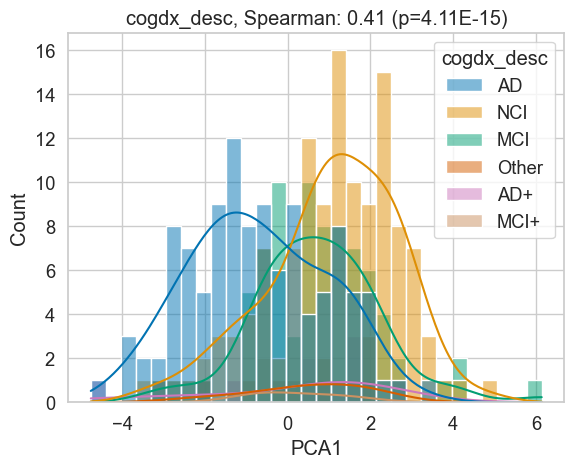

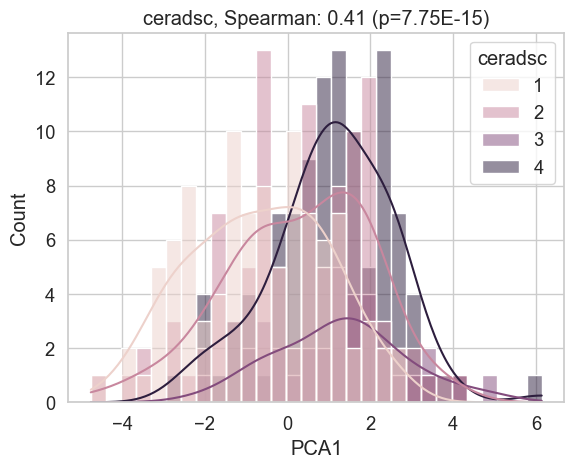

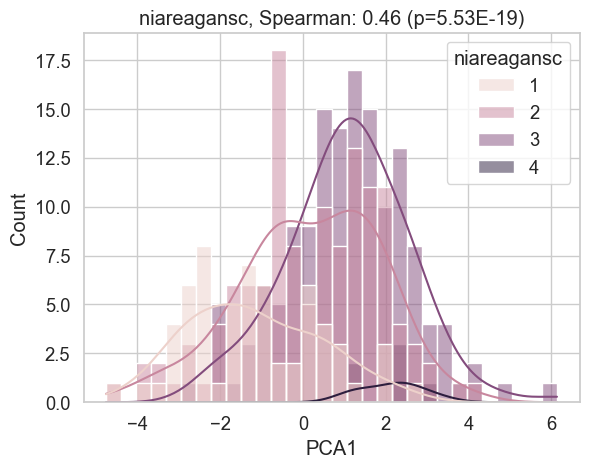

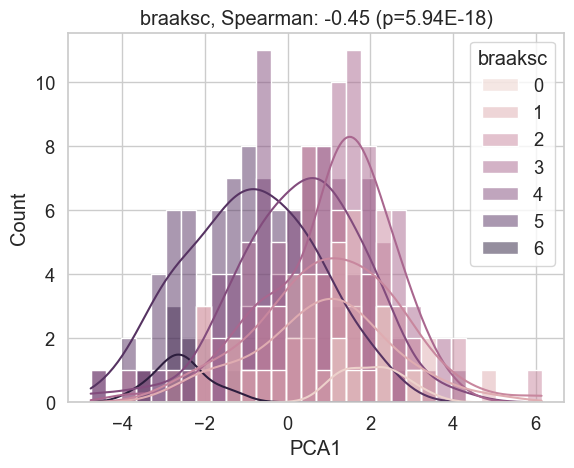

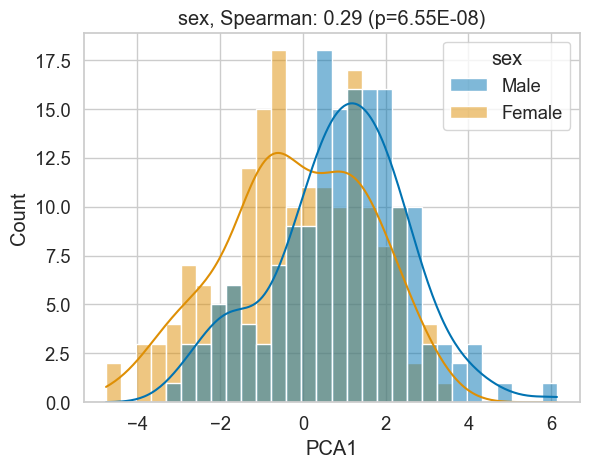

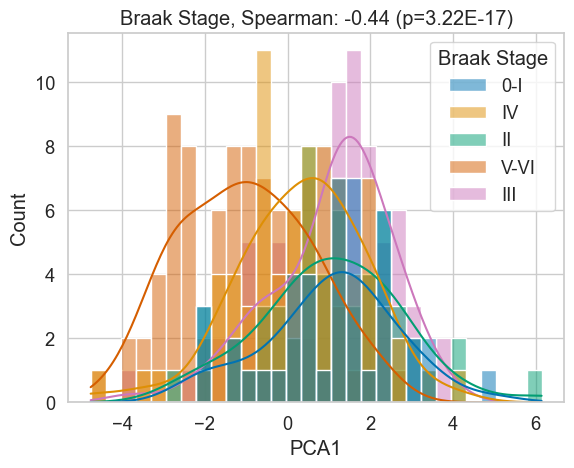

In [73]:

for col in ["Disease State", "cogdx_desc", "ceradsc", "niareagansc", "braaksc", "sex", "Braak Stage"]:
    sp = spearmanr(ddata.obs["PCA1"], ddata.obs[col])
    plt.figure()
    sns.histplot(ddata.obs, x="PCA1", hue=col, bins=30, kde=True, common_norm=False)
    plt.title(f"{col}, Spearman: {sp.correlation:.2f} (p={sp.pvalue:.2E})")
    plt.show()

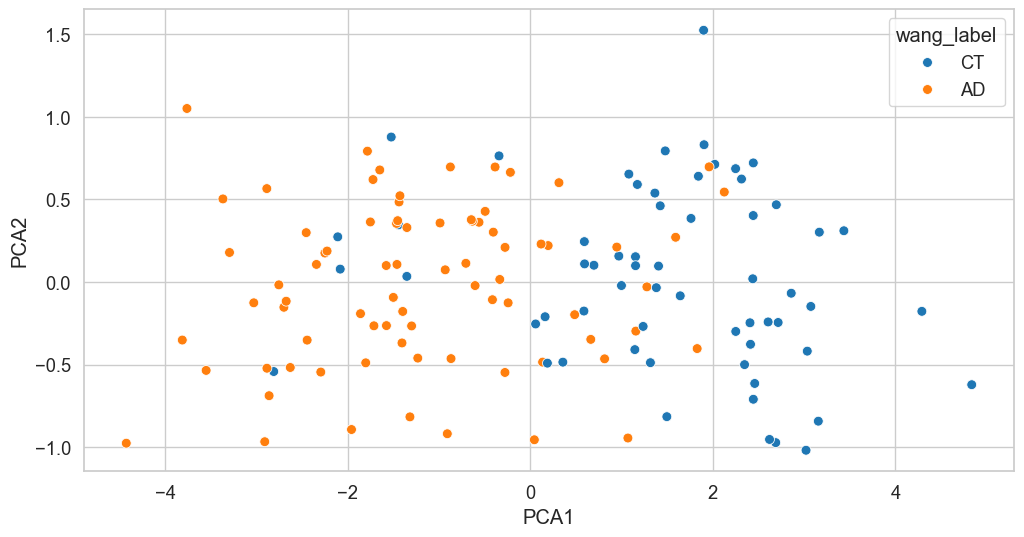

ValueError: Could not interpret value `UMAP1` for `x`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>

In [11]:
# Plot PCA and UMAP of just the train and test data
plt.figure(figsize=(12, 6))
sns.scatterplot(data=ddata_noint.obs, x="PCA1", y="PCA2", 
                hue="wang_label", hue_order=["CT", "AD"], s=MARKER_SIZE, palette="tab10")
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=ddata_noint.obs, x="UMAP1", y="UMAP2", 
                hue="wang_label", hue_order=["CT", "AD"], s=MARKER_SIZE, palette="tab10")
plt.show()

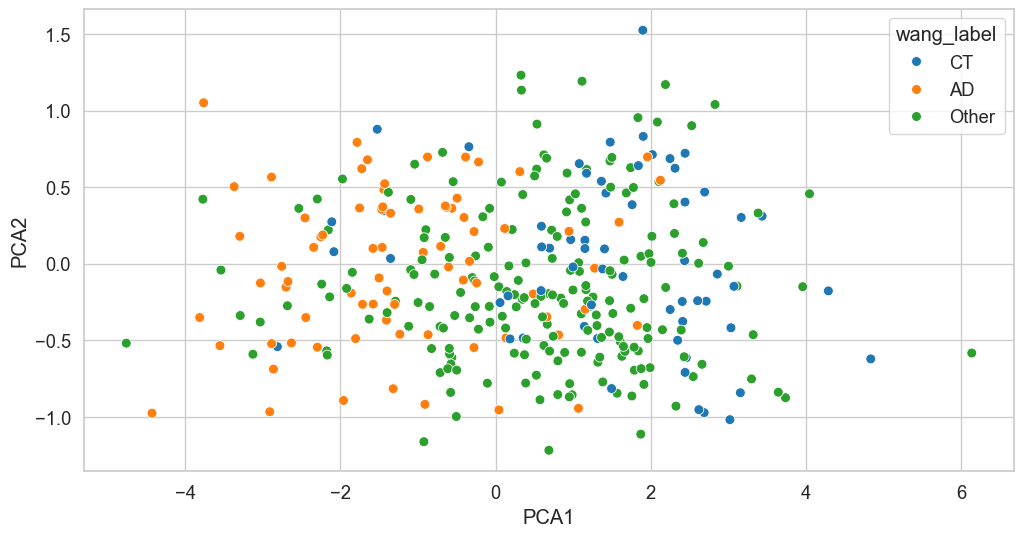

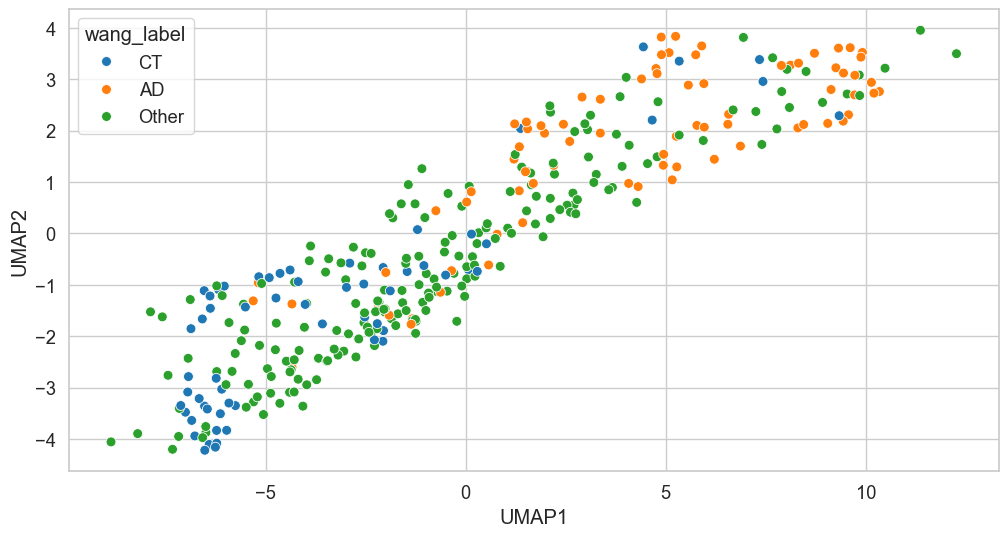

In [ ]:
# Plot PCA and UMAP of all data (by projecting the heldout data into the PCA/UMAP space)
plt.figure(figsize=(12, 6))
sns.scatterplot(data=ddata.obs, x="PCA1", y="PCA2", hue="wang_label", s=MARKER_SIZE, palette="tab10", hue_order=["CT", "AD", "Other"])
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=ddata.obs, x="UMAP1", y="UMAP2", hue="wang_label", s=MARKER_SIZE, palette="tab10", hue_order=["CT", "AD", "Other"])
plt.show()

In [ ]:
ddata.obs.columns

Index(['study', 'scaled_to', 'agreeableness', 'conscientiousness',
       'extraversion_6', 'neo_altruism', 'neo_trust', 'neuroticism_12',
       'openness', 'neuroticism_48',
       ...
       'UMAP1', 'UMAP2', 'PCA1', 'PCA2', 'PCA3', 'PCA4', 'UMAP1D', 'cogdx_num',
       'extreme_case', 'y_pred_hard'],
      dtype='object', length=146)

In [90]:
ddata.obs["cogdx_desc"]

projid
1211411      AD
3713990     NCI
3889845     MCI
6804844     MCI
7253015      AD
           ... 
94430339    MCI
95491648    NCI
95919181    MCI
96095092    NCI
98953007     AD
Name: cogdx_desc, Length: 339, dtype: object

In [91]:
ddata.obs["cogdx_num"] = ddata.obs["cogdx_desc"].map({
    "AD+": 3,
    "AD": 3,
    "MCI+": 2,
    "MCI": 2,
    "NCI": 1,
    "Other": None,
})

<Axes: xlabel='UMAP1', ylabel='UMAP2'>

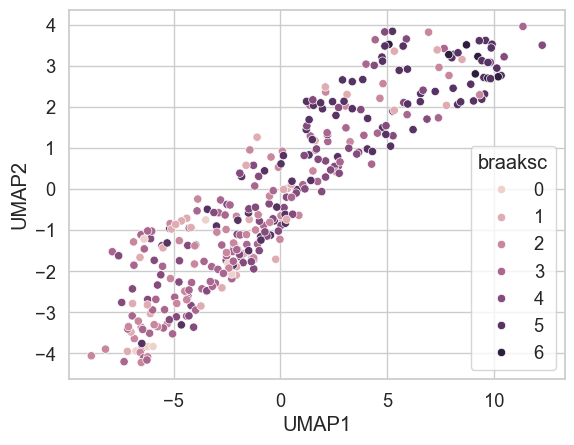

In [92]:
sns.scatterplot(data=ddata.obs, x="UMAP1", y="UMAP2", hue="braaksc")

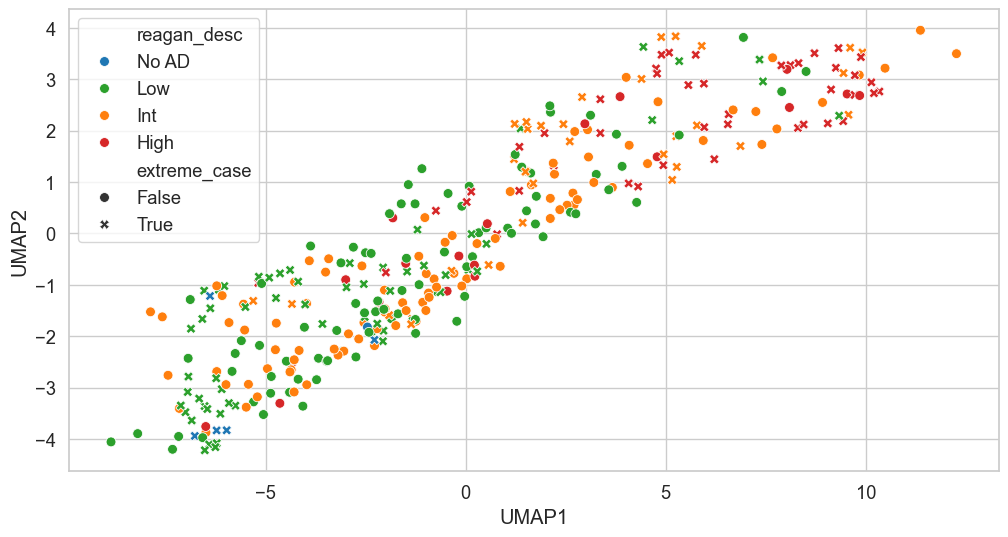

In [93]:
BLUE = "#1f77b4"
ORANGE = "#ff7f0e"
GREEN = "#2ca02c"
RED = "#d62728"

hue_order = ["No AD", "Low", "Int", "High"]
ddata.obs["extreme_case"] = ddata.obs["wang_label"] != "Other" 
palette = sns.color_palette([BLUE, GREEN, ORANGE, RED])

plt.figure(figsize=(12, 6))
sns.scatterplot(data=ddata.obs, x="UMAP1", y="UMAP2", 
                hue="reagan_desc", s=50, palette=palette, hue_order=hue_order,
                style="extreme_case", style_order=[False, True])
plt.show()

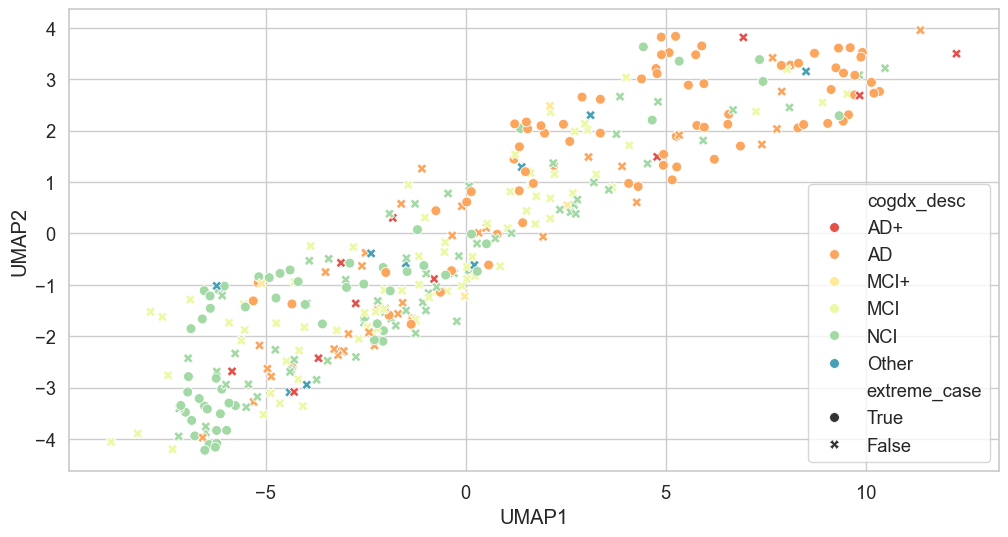

In [94]:
hue_order = ["Other", "NCI", "MCI", "MCI+", "AD", "AD+"][::-1]
# hue_order = ["NCI", "MCI", "AD"][::-1]
plt.figure(figsize=(12, 6))
sns.scatterplot(data=ddata.obs, x="UMAP1", y="UMAP2", hue="cogdx_desc", s=MARKER_SIZE,
                palette="Spectral", hue_order=hue_order, style="extreme_case", 
                legend="full", style_order=[True, False])
plt.show()

<Axes: xlabel='y_pred', ylabel='Count'>

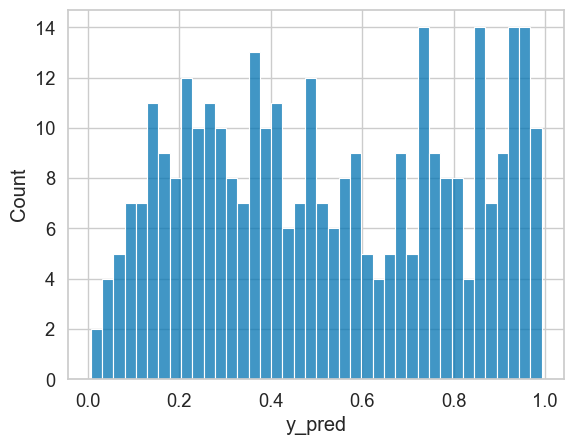

In [95]:
sns.histplot(ddata.obs["y_pred"], bins=40)

### Confounding effect in msex metadata

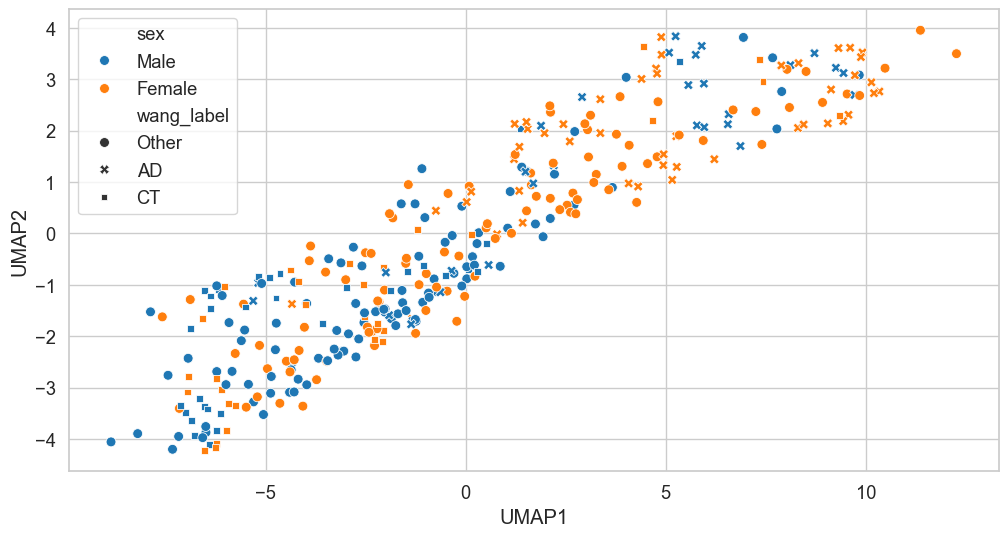

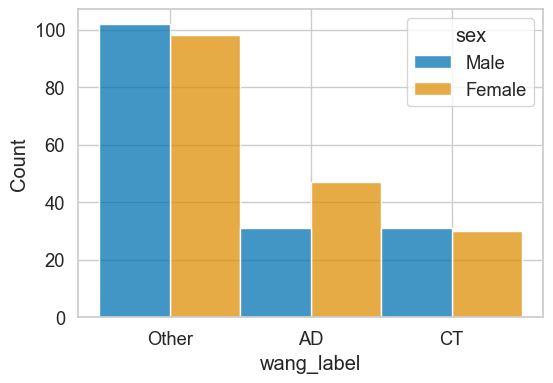

In [96]:
# UMAP color by sex and wang_label
plt.figure(figsize=(12, 6))
sns.scatterplot(data=ddata.obs, x="UMAP1", y="UMAP2", hue="sex", style="wang_label", s=MARKER_SIZE, palette="tab10")
plt.show()

# Show distribution per class in histplot
plt.figure(figsize=(6, 4))
sns.histplot(data=ddata.obs, x="wang_label", hue="sex", multiple="dodge")
plt.show()

In [97]:
ddata.obs["y_pred_hard"] = (ddata.obs["y_pred"] > 0.5).map({True: 1, False: 0})


Mean ypred: M=0.443, F=0.603


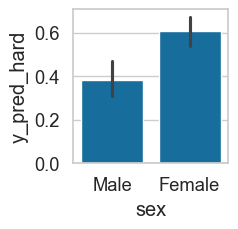

In [98]:
# Mean prediction per F/M
y_pred_mean_m = ddata[ddata.obs["sex"] == "Male"].obs["y_pred"].mean()
y_pred_mean_f = ddata[ddata.obs["sex"] == "Female"].obs["y_pred"].mean()

print(f"Mean ypred: M={y_pred_mean_m:.3f}, F={y_pred_mean_f:.3f}")

fig, ax = plt.subplots(figsize=(2, 2))
sns.barplot(ddata.obs, y="y_pred_hard", x="sex", ax=ax)
plt.show()

In [77]:
# drop train
ddata_notrain = ddata[ddata.obs["cv_set"] != "train"].copy()
print(ddata_notrain)

ddata_notrain.obs["wang_label"].value_counts()

AnnData object with n_obs × n_vars = 227 × 128
    obs: 'study', 'scaled_to', 'agreeableness', 'conscientiousness', 'extraversion_6', 'neo_altruism', 'neo_trust', 'neuroticism_12', 'openness', 'neuroticism_48', 'neuroticism_6', 'apoe_genotype', 'clin_dlb', 'cogdx', 'cogdx_stroke', 'dxpark', 'cogn_ep_lv', 'cogn_po_lv', 'cogn_ps_lv', 'cogn_se_lv', 'cogn_wo_lv', 'cognep_random_slope', 'cogng_random_slope', 'cognpo_random_slope', 'cognps_random_slope', 'cognse_random_slope', 'cognwo_random_slope', 'cogn_global_lv', 'age_bl', 'age_death', 'educ', 'msex', 'race', 'spanish', 'agefirst', 'agelast', 'menoage', 'mensage', 'natura', 'othspe00', 'whatwas', 'alcohol_g_bl', 'ldai_bl', 'q3smo_bl', 'q4smo_bl', 'smoking', 'chd_cogact_freq', 'lifetime_cogact_freq_bl', 'ma_adult_cogact_freq', 'ya_adult_cogact_freq', 'phys5itemsum_bl', 'phys5itemsum_lv', 'soc_net_bl', 'social_isolation_avg', 'social_isolation_lv', 'hypertension_bl', 'cancer_bl', 'diabetes_sr_rx_bl', 'headinjrloc_bl', 'thyroid_bl', 'chf_bl

wang_label
Other    200
AD        15
CT        12
Name: count, dtype: int64

In [78]:
# Predict sex from embeddings:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

X = ddata_notrain.X
y = ddata_notrain.obs["msex"]

clf = LogisticRegression(max_iter=1000)
np.mean(cross_val_score(clf, X, y, cv=5))

0.9781642512077294

## Check other possible covariates

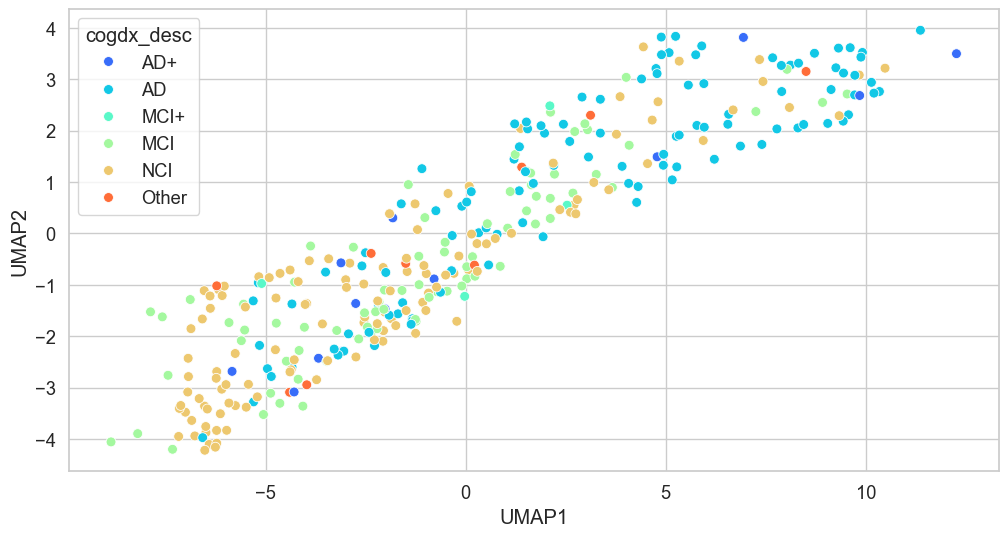

In [79]:
plt.figure(figsize=(12, 6))
hue_order = ["AD+", "AD", "MCI+", "MCI", "NCI", "Other"]
sns.scatterplot(data=ddata.obs, x="UMAP1", y="UMAP2", hue="cogdx_desc", s=MARKER_SIZE, palette="rainbow", hue_order=hue_order)
plt.show()

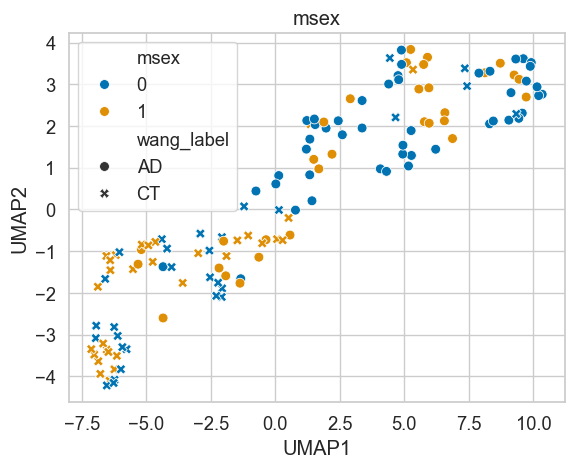

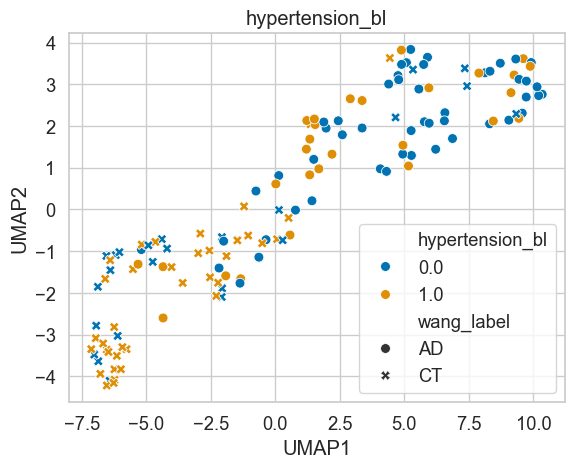

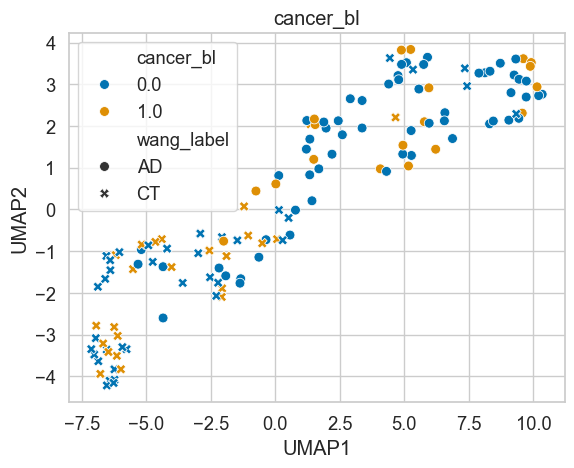

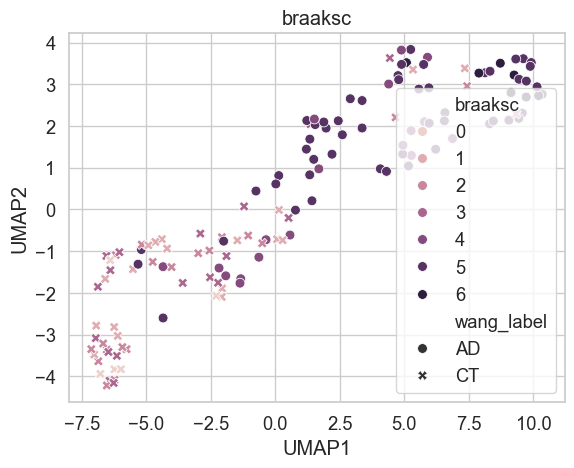

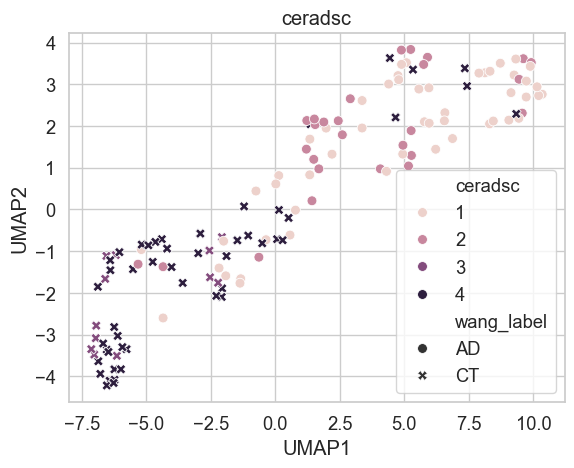

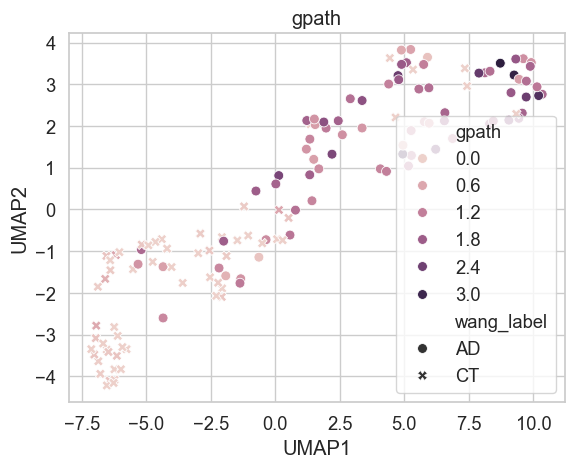

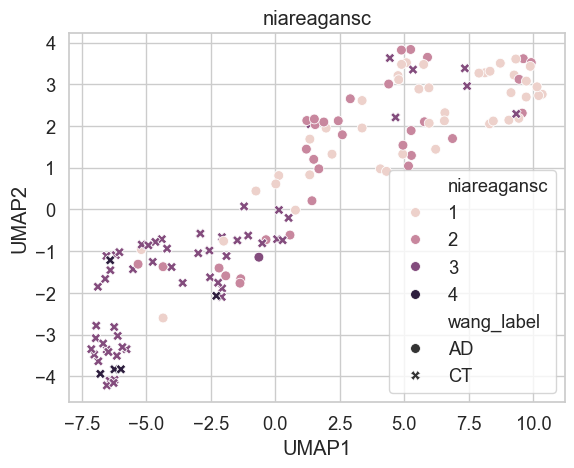

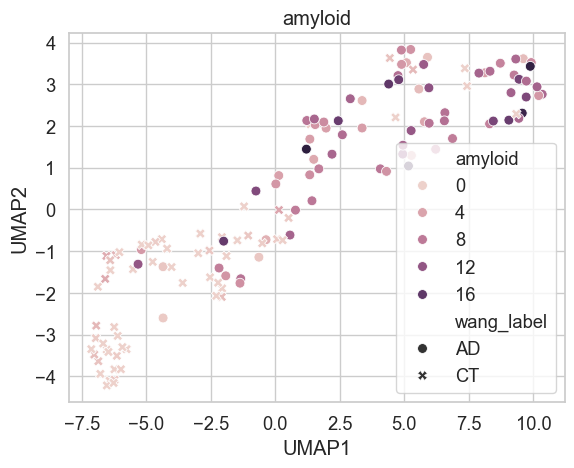

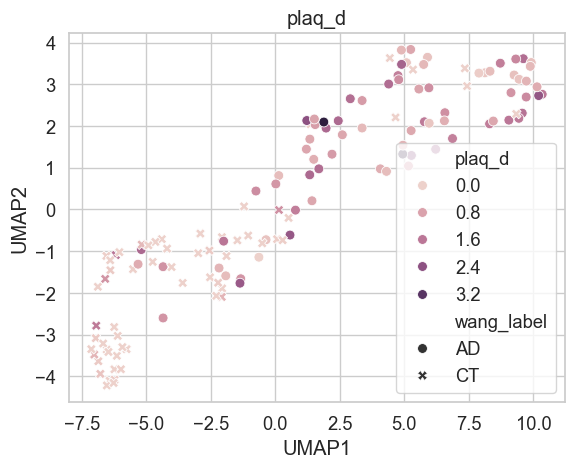

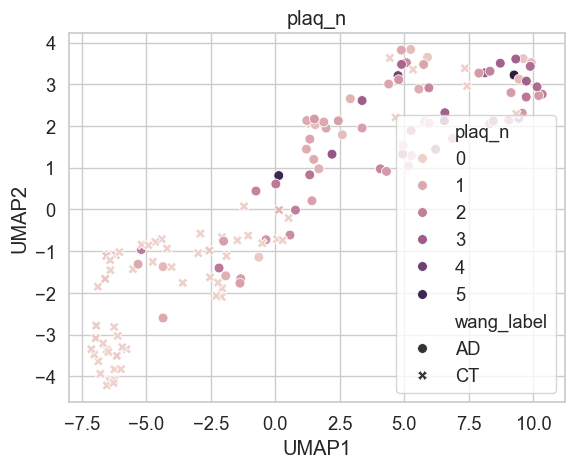

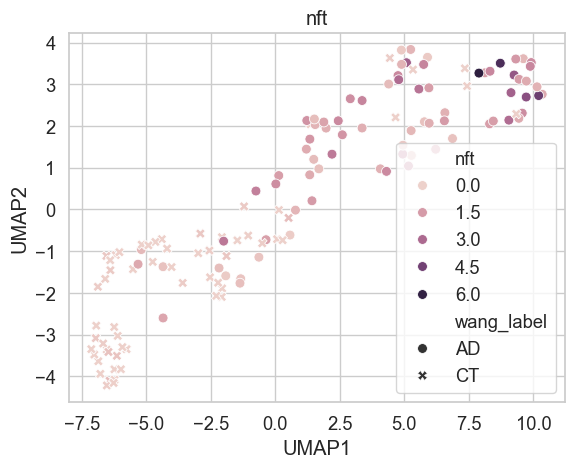

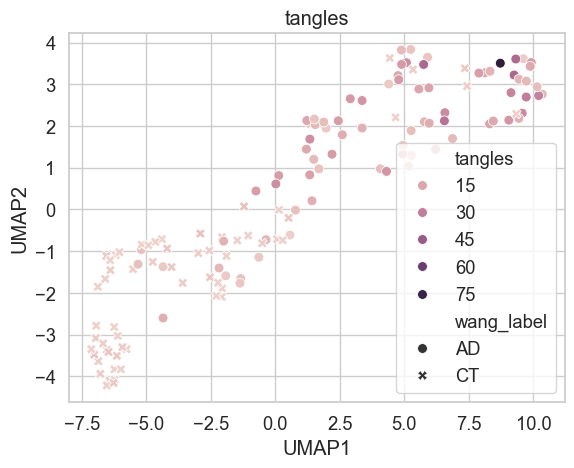

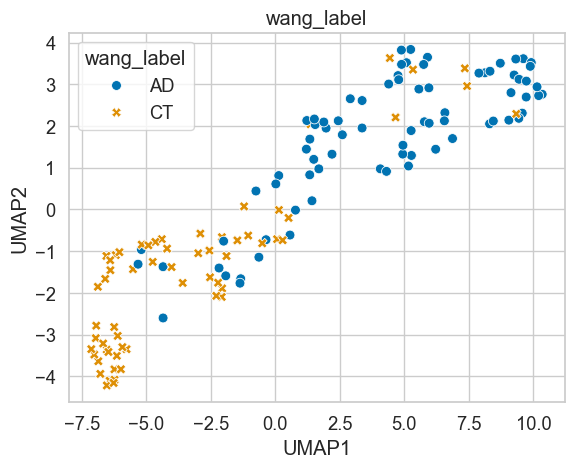

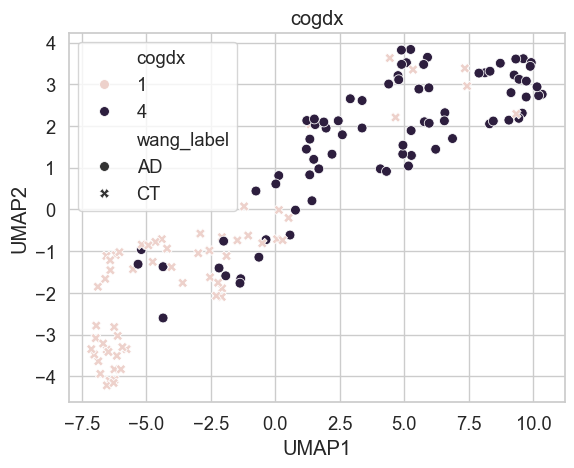

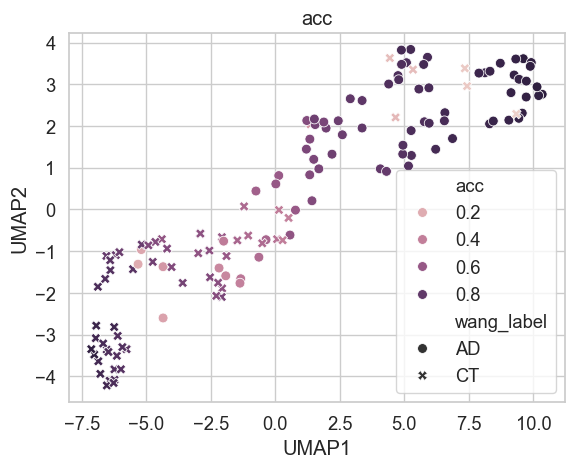

In [80]:
for col in [
    "msex",
    "hypertension_bl",
    "cancer_bl",
    "braaksc",
    "ceradsc",
    "gpath",
    "niareagansc",
    "amyloid",
    "plaq_d",
    "plaq_n",
    "nft",
    "tangles",
    "wang_label",
    "cogdx",
    "acc"
]:
    plt.figure()
    sns.scatterplot(data=ddata_noint.obs, x="UMAP1", y="UMAP2", hue=col, s=MARKER_SIZE, style="wang_label")
    plt.title(col)
    plt.show()

## (Old code) outlier stuff

Stuff below was to check the CT composition of the outliers.

It's all old code, but too cool to throw away.

In [81]:
# obsm_scaled = ddata.obsm["celltype_counts"] / ddata.obsm["celltype_counts"].sum(axis=1)[:, None]

# df = pd.DataFrame(obsm_scaled, index=ddata.obs_names, columns=ddata.uns["obsm_ctcounts_cols"])
# df["outlier"] = df.index.isin(outliers)

# df_long = df.melt(id_vars="outlier", var_name="celltype", value_name="count")

# fig, ax = plt.subplots(figsize=(20, 4), dpi=500)
# sns.violinplot(data=df_long, x="celltype", y="count", hue="outlier", ax=ax)
# # rotate x labels
# plt.xticks(rotation=90)
# # plt.yscale("log")
# plt.show()

# # Test for differential abundance between outliers and non-outliers
# from scipy.stats import mannwhitneyu

# pvals = []
# for celltype in df.columns[:-1]:
#     pval = mannwhitneyu(df[df["outlier"]][celltype], df[~df["outlier"]][celltype]).pvalue
#     pvals.append(pval)
    
# df_pvals = pd.DataFrame({"celltype": df.columns[:-1], "pval": pvals})

# # Correct for multiple testing
# from statsmodels.stats.multitest import multipletests
# df_pvals["pval_corr"] = multipletests(df_pvals["pval"], method="bonferroni")[1]

# print(df_pvals)

# plt.scatter(ddata_noint.obs["UMAP1"], ddata_noint.obs["UMAP2"], c=ddata_noint.obs["cellcount"], s=10)
# plt.colorbar()

# for i, ct in enumerate(ddata.uns["obsm_ctcounts_cols"]):
#     plt.figure()
#     plt.scatter(ddata.obs["PCA1"], ddata.obs["PCA2"], c=ddata.obsm["celltype_counts"][:, i], s=10)
#     plt.title("Cell type counts: " + ct)
#     plt.colorbar()
#     plt.show()